In [1]:
# Import thư viện
import imageio
import joblib as jlb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pdp
import seaborn as sbn
import os

from IPython.display import Image
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [2]:
# Cấu hình đường dẫn
folder = "../"
output_dir = folder + "Output"

# Tạo thư mục nếu chưa có
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Chuẩn bị dữ liệu
data = pd.read_csv(folder + '../Data/Social_Network_Ads.csv')
print(data.head())
print("=========================================================")
print(data.info())

print("=========================================================")

x = data.drop(['User ID', 'EstimatedSalary_K', 'Purchased'], axis=1)
print(x.head())

print("=======================================================")

y = data.Purchased
print(y.head())

print("=======================================================")

print("Các nhãn (classes):", y.unique())

    User ID  Gender  Age  EstimatedSalary  EstimatedSalary_K  Purchased
0  15624510    Male   19            19000                 19          0
1  15810944    Male   35            20000                 20          0
2  15668575  Female   26            43000                 43          0
3  15603246  Female   27            57000                 57          0
4  15804002    Male   19            76000                 76          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            400 non-null    int64 
 1   Gender             400 non-null    object
 2   Age                400 non-null    int64 
 3   EstimatedSalary    400 non-null    int64 
 4   EstimatedSalary_K  400 non-null    int64 
 5   Purchased          400 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 18.9+ KB
None
   Gender  Age  EstimatedSalary


In [4]:
# Chuyển Gender thành kiểu Numerical
sex = {'Male':1, 'Female':0}
x['Male'] = [sex[i] for i in data.Gender]
x  = x.drop(['Gender'], axis = 1)

print(pd.concat([x, y], axis = 1).head())

   Age  EstimatedSalary  Male  Purchased
0   19            19000     1          0
1   35            20000     1          0
2   26            43000     0          0
3   27            57000     0          0
4   19            76000     1          0


In [5]:
# Chia train/test 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

Train: (320, 3), Test: (80, 3)


In [ ]:
# Xây dựng mô hình Decision Tree (giữ tham số mặc định)
clf = DecisionTreeClassifier(criterion='entropy') # Mặc định là gini
model = clf.fit(x_train, y_train)

In [7]:
# Lưu mô hình
mdl_path = os.path.join(output_dir, 'DecisionTree_Sna.mdl')
jlb.dump(model, mdl_path)
print(f"Đã lưu mô hình: {mdl_path}")

Đã lưu mô hình: ../Output\DecisionTree_Sna.mdl


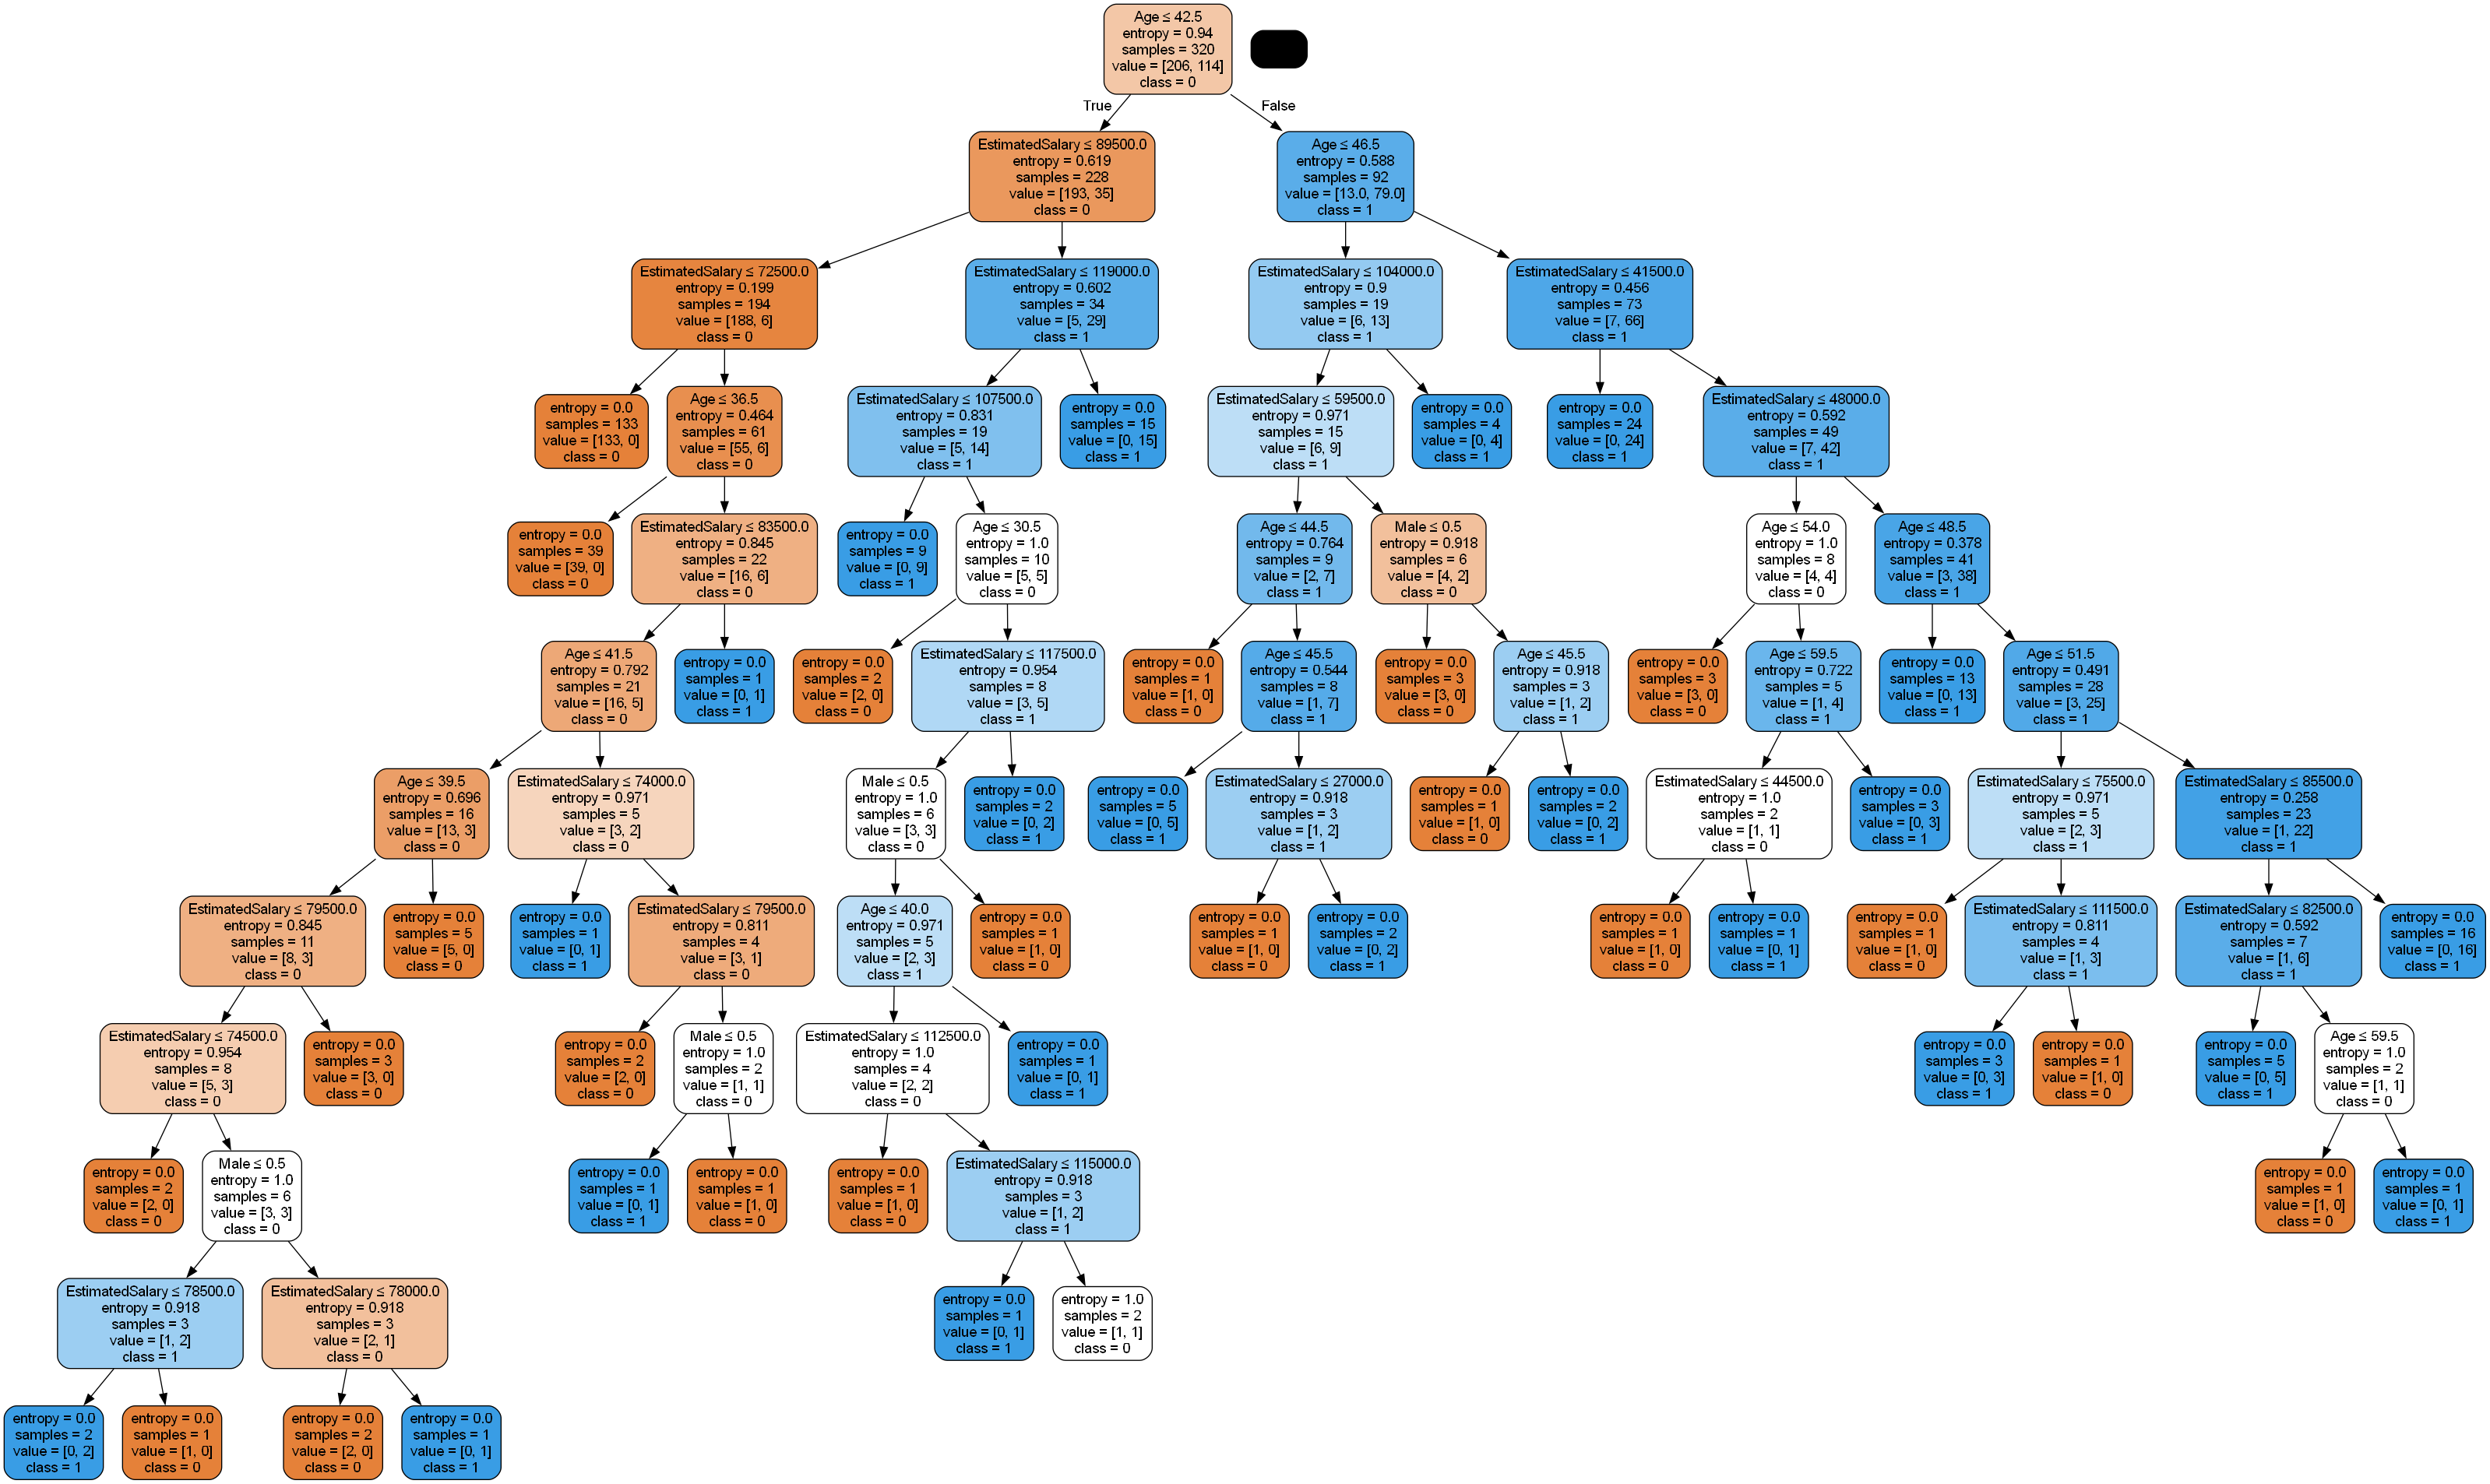

In [8]:
# ----------------------------------------------------------
# 5. Xuất & hiển thị cây quyết định (graphviz + pydotplus)
# ----------------------------------------------------------
dot_data = tree.export_graphviz(
    model,
    out_file=None,
    feature_names=x.columns,
    class_names=np.unique(y).astype(str),
    filled=True,
    rounded=True,
    special_characters=True
)
graph = pdp.graph_from_dot_data(dot_data)

png_path = os.path.join(output_dir, "DecisionTree_Sna.png")
pdf_path = os.path.join(output_dir, "DecisionTree_Sna.pdf")

# ghi file
graph.write_png(png_path)
graph.write_pdf(pdf_path)

# (Tùy môi trường, Image(...) có thể hiển thị trong notebook)
try:
    display(Image(graph.create_png()))
except Exception:
    print(f"Đã xuất cây xuống: {png_path} và {pdf_path}")

C:\Users\Phu\AppData\Local\Temp\ipykernel_18868\241549063.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  photo = imageio.imread(png_path)


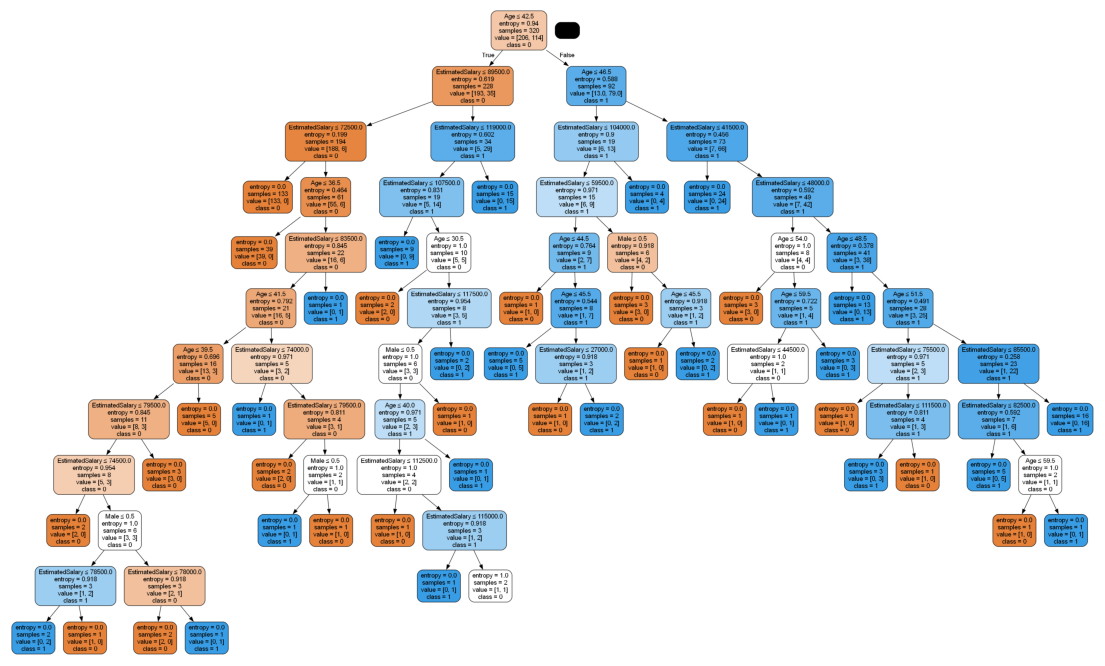

In [9]:
# Hiển thị ảnh cây (nếu file được tạo) để đảm bảo có output
if os.path.exists(png_path):
    photo = imageio.imread(png_path)
    plt.figure(figsize=(14,14))
    plt.imshow(photo)
    plt.axis('off')
    plt.show()

In [10]:
# Dự đoán và kiểm thử
model = jlb.load(mdl_path)
y_pred = model.predict(x_test)

In [11]:
# So sánh kết quả
df_compare = pd.DataFrame({'Thực tế': y_test.values, 'Dự đoán': y_pred})
print(df_compare.head(10))

print(f"\nSố trường hợp dự đoán ĐÚNG: {(y_pred == y_test).sum()}/{len(y_test)}")

   Thực tế  Dự đoán
0        0        0
1        0        1
2        0        0
3        0        0
4        0        0
5        1        1
6        0        0
7        1        0
8        1        1
9        1        0

Số trường hợp dự đoán ĐÚNG: 67/80


In [12]:
# ----------------------------------------------------------
# 6. Đánh giá
# ----------------------------------------------------------
# Các chỉ số chung (dùng average='macro' cho đa lớp)
scores = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (macro)': precision_score(y_test, y_pred, average='macro'),
    'Recall (macro)': recall_score(y_test, y_pred, average='macro'),
    'F1-score (macro)': f1_score(y_test, y_pred, average='macro')
}

print("\n=== 🔍 ĐÁNH GIÁ MÔ HÌNH Decision Tree (Iris) ===")
for name, val in scores.items():
    print(f"{name:20s}: {val*100:.2f}%")

print("\n=== 📊 Báo cáo chi tiết ===")
print(classification_report(y_test, y_pred))



=== 🔍 ĐÁNH GIÁ MÔ HÌNH Decision Tree (Iris) ===
Accuracy            : 83.75%
Precision (macro)   : 82.33%
Recall (macro)      : 82.79%
F1-score (macro)    : 82.55%

=== 📊 Báo cáo chi tiết ===
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.77      0.79      0.78        29

    accuracy                           0.84        80
   macro avg       0.82      0.83      0.83        80
weighted avg       0.84      0.84      0.84        80




Ma trận nhầm lẫn:
 [[44  7]
 [ 6 23]]


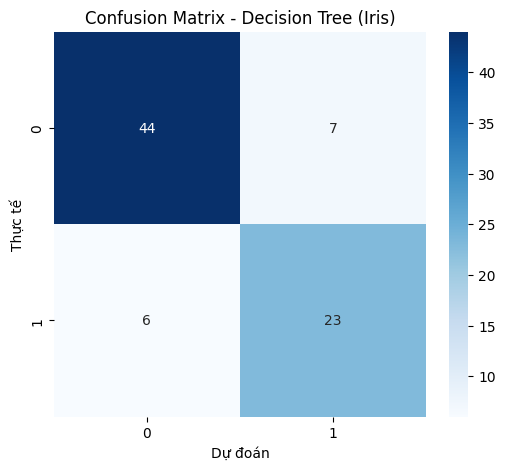

In [13]:
# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("\nMa trận nhầm lẫn:\n", cm)

plt.figure(figsize=(6,5))
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - Decision Tree (Iris)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()


Feature importances:
 EstimatedSalary    0.495736
Age                0.482867
Male               0.021398
dtype: float64


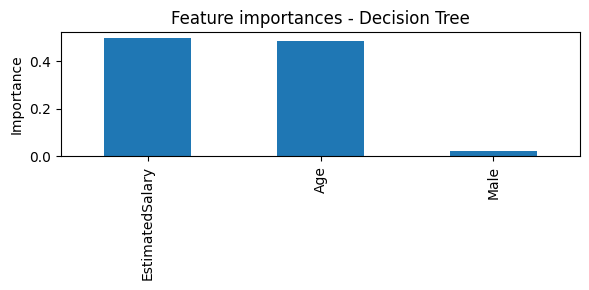

In [14]:
# Feature Importances
fi = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)
print("\nFeature importances:\n", fi)

plt.figure(figsize=(6,3))
fi.plot(kind='bar')
plt.title('Feature importances - Decision Tree')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [15]:
# ----------------------------------------------------------
# 9. Vòng lặp tương tác dự đoán mẫu đơn lẻ (giữ giao diện giống ban đầu)
# ----------------------------------------------------------
labels = np.array(['KHÔNG mua', 'MUA'])
model_load = jlb.load(mdl_path)

tiep = 'C'
while (tiep.upper() == 'C'):
    try:
        idx = int(input(f'Nhập chỉ số dòng từ 0 đến {len(x_test)-1} (hoặc -1 để thoát): '))
        if idx == -1:
            break
        idx = idx % len(x_test)
        X_new = x_test.iloc[[idx]]
        y_pred_single = model_load.predict(X_new)
        print('Mẫu', X_new.to_string(), end='')

        if np.issubdtype(type(y_pred_single[0]), np.integer):
            print('    được dự đoán là', labels[y_pred_single[0]])
        else:
            print('    được dự đoán là', y_pred_single[0])
    except Exception as ex:
        print("Lỗi nhập liệu hoặc ngoại lệ:", ex)
    tiep = input('Tiếp tục (C/K) ? ')